In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

# Short analysis of the biased run

## O-Ca2+ distance as a function of time

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1666/1465859466.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_hills = plumed.read_as_pandas("HILLS")
No handles with labels found to put in legend.


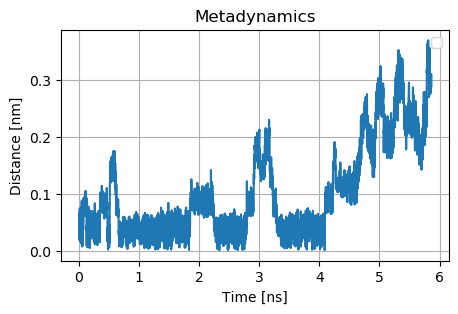

In [101]:
data_hills = plumed.read_as_pandas("HILLS")
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(data_hills["time"]*0.001, data_hills["d1"])
plt.xlabel("Time [ns]")
plt.ylabel("Increment of bias potential [kJ/mol]")
plt.grid()
plt.title("Metadynamics")
plt.ylabel("Distance [nm]")
plt.xlabel("Time [ns]")
plt.legend(loc="best")

## Metadynamics reweighting bias $\beta[V(s,t) - c(t)]$ 

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1666/3904181208.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar = plumed.read_as_pandas("COLVAR")


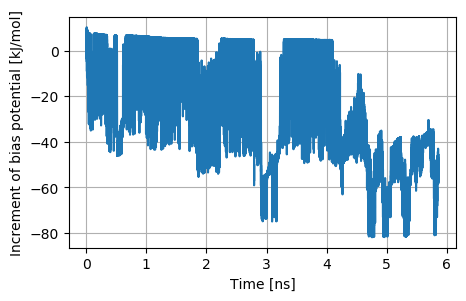

In [23]:
data_colvar = plumed.read_as_pandas("COLVAR")
plt.plot(data_colvar["time"]*0.001, data_colvar["metad.rbias"])
plt.xlabel("Time [ns]")
plt.ylabel("Increment of bias potential [kJ/mol]")
plt.grid()

# Interpretation of the plots

The height must be computed with the bias at the previous step. In fact, you can write the updating law of the bias employing the insertion time as a label. A good notation should in fact be:
$$
B_{t'+\tau_G}(\{s_i(t)\}, t)=B_{t'}(\{s_i(t)\}, t)+W\exp{\left(-\frac{B_{t'}(\{s_i(t)\}, t)}{\Delta T}\right)}\exp{\left(-\sum_{i=1}^{N}\frac{(s_i(t)-s_i(t'))^2}{2\sigma_i^2}\right)}
$$

### Metadynamics bias
The increment of the bias potential at time $t>t'$: 
$$
W \exp{\left(-\frac{B_{t'}(\{s_i(t)\}, t)}{\Delta T}\right)} \exp{\left(-\sum_{i=1}^{N}\frac{(s_i(t)-s_i(t'))^2}{2\sigma_i^2}\right)}
$$
where $t'$ is a multiple of $\tau_G$. I think that this increment can go to zero when the distance $s_i(t)-s_i(t')$ is huge, namely, when the CV has deviated considerably from the value of the same CV at the time of Gaussian insertion. This difference $s_i(t)-s_i(t')$ increases when we pass from one basin to another.  This explains the drop of the bias in around 10 ns. 


### Plot of the heights of the Gaussians
Around 10 ns, we have a clear change in the height of the Gaussians, which originally is set equal to 1. This change is clearly related to the exploration of another basin. We said that around 10 ns the bias added drops to zero, but this determines an increase in the height since the factor 
$$
W\exp{\left(-\frac{B_{t'}(\{s_i(t)\}, t)}{\Delta T}\right)}
$$
goes to $W$. 



# Comparison between free energy surfaces
We use the tool `sum_hills` to judge the convergence of the free energy profile as a function of the simulated time. With this command we generate many free energy files (`fes`), each one containing the estimate of the free energy up to that point in time.
```
plumed sum_hills --hills HILLS --mintozero
```

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1666/1764525925.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_fes = plumed.read_as_pandas("fes.dat")


(0, 0.4)

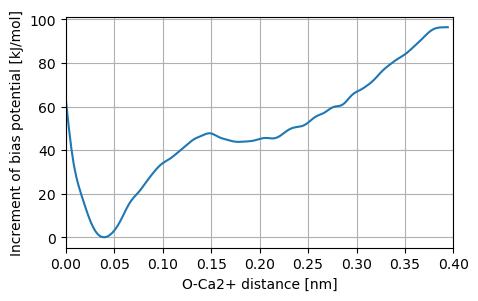

In [22]:
data_fes = plumed.read_as_pandas("fes.dat")
plt.plot(data_fes["d1"], data_fes["file.free"])
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Increment of bias potential [kJ/mol]")
plt.grid()
plt.xlim([0, 0.4])

## Biased and unbiased histograms as a function of O-Ca2+ distance
Here we consider the COLVAR file. Remember that the COLVAR file has more samples than the HILLS file. since the deposition PACE of the run is bigger than 100 (STRIDE for COLVAR). We expect the unbiased distribution to be very similar to the distribution of the first run without metadynamics. Be careful: always use $kT=1$ because plumed always expresses quantities multiplied by $\beta$. 

IMPORTANT: note that `sum_hills` is just summing the Gaussians to reconstruct the free energy as (proportional to) the applied potential.

Text(0, 0.5, 'Probability density')

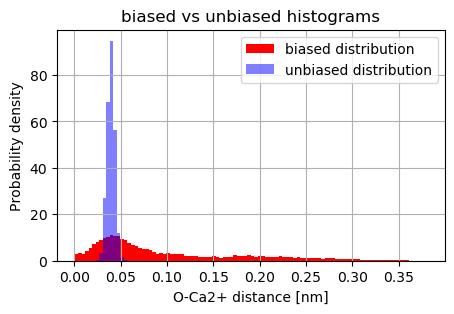

In [180]:
val_bias, bins_bias, patches_bias = plt.hist(data_colvar["d1"], bins=100, density=True, color='r', label="biased distribution")
kT = 1
w = [math.exp(data_colvar["metad.rbias"][i])/kT for i in range(len(data_colvar["metad.rbias"]))]
val_unbias, bins_unbias, patches_unbias = plt.hist(data_colvar["d1"], bins=100, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution")
plt.grid()
plt.legend(loc="best")
plt.title("biased vs unbiased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")

# Note that len(bins_bias) = len(val_bias) + 1 because bins_bias contains the edges of the bins

Text(0, 0.5, 'Free energy surface')

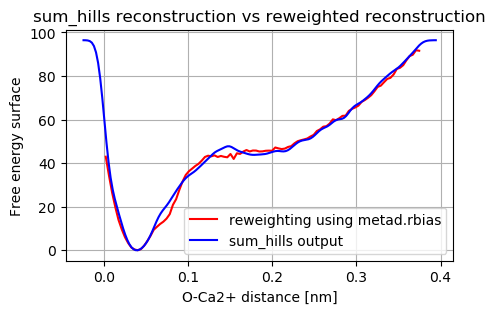

In [220]:
F = []
dist = []
kT = 1
mesh = (bins_unbias[1] - bins_unbias[0])/2
i = 0
min = -kT * math.log(val_unbias[0])

while val_unbias[i] != 0 and i<len(val_unbias)-1:
    F.append(-kT * math.log(val_unbias[i]))
    dist.append(bins_unbias[i] + mesh)
    if F[i] < min:
        min = F[i]
    i = i + 1

# Remove the offset
F = F - min*np.ones(len(F))

# From the fes.dat file (elaboration of the HILLS file, via sum_hills)
plt.plot(dist, F, 'r',label="reweighting using metad.rbias")
plt.plot(data_fes["d1"], data_fes["file.free"], 'b', label="sum_hills output")
plt.grid()
plt.legend(loc="best")
plt.title("sum_hills reconstruction vs reweighted reconstruction")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Free energy surface")


# The small difference is due to the arbitrary shift

## Curiosity: weird ideas behind plumed code
Now I select from `COLVAR` the values of `metad.rbias` corresponding to the values of $t_k$ reported in the rows of HILLS. The $t_k$ simply represent the different times at which Gaussians are deposited and in the case of adaptive frequency metadynamics, they are not spaced regularly. We remind that for this simulation, a `PACE` of 100 corresponds to a gap of 0.2 between two consecutive $t_k$. 

As a check, you can verify that `len(data_hills["d1"])` and `len(new_metad_rbias)` are the same number.

We want to compare two unbiased distributions of `d1`: one from the whole COLVAR file and the other from the selected rows of COLVAR, which (hopefully) should be equal to the rows of HILLS. 

In [209]:
new_d1 = []
new_d1.append(0)

new_metad_rbias = []
new_metad_rbias.append(0)

# I can already compute the new weights 
new_w = []
new_w.append(math.exp(data_colvar["metad.rbias"][0])/kT)

# Always remeber the initialization !
i = 0
j = 0

# Get the indexes of the lines
while i + j < len(data_colvar["metad.pace"]):

    j = int(data_colvar["metad.pace"][i]/100)

    new_metad_rbias.append(data_colvar["metad.rbias"][i + j])
    new_d1.append(data_colvar["d1"][i + j])
    new_w.append(math.exp(data_colvar["metad.rbias"][i + j])/kT)
    i = i + j


# You can check that the values of d1 are the same reported in HILLS:
j = 0

for i in range(len(new_d1)):
    if abs(new_d1[i] -  data_hills["d1"][i]) > 1:
        print("Please be careful: data do not correspond ", new_d1[i] -  data_hills["d1"][i])
        j = j + 1
if j == 0:
    print("HILLS and COLVAR data correspond")

HILLS and COLVAR data correspond


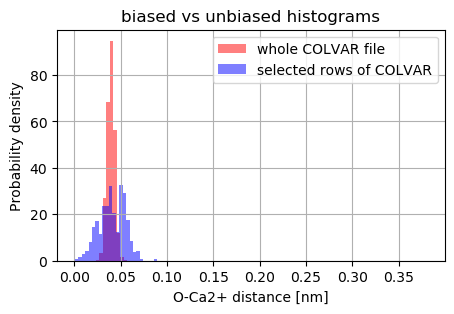

In [210]:
val_unbias, bins_unbias, patches_unbias = plt.hist(data_colvar["d1"], bins=100, weights=w, density=True, alpha = 0.5, color= 'r', label="whole COLVAR file")
plt.grid()
plt.title("biased vs unbiased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")

# Now we have the data from HILLS and the metad.rbias as well. We can do a new instogram
new_val_unbias, new_bins_unbias, new_patches_unbias = plt.hist(data_hills["d1"], bins=100, weights=new_w, density=True, alpha = 0.5, color= 'b', label="selected rows of COLVAR")
plt.legend(loc="best")

# Probably the normalization cuts away the sides of the "whole COLVAR file"


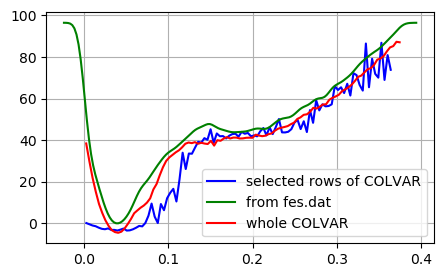

In [211]:
new_F = []
new_dist = []
mesh = (new_bins_unbias[1] - new_bins_unbias[0])/2
i = 0

while new_val_unbias[i] != 0 and i<len(new_val_unbias)-1:
    new_F.append(-kT * math.log(new_val_unbias[i]))
    new_dist.append(new_bins_unbias[i] + mesh)
    i = i + 1


plt.plot(new_dist, new_F, 'b', label="selected rows of COLVAR")
plt.plot(data_fes["d1"], data_fes["file.free"], 'g',label="from fes.dat")
plt.plot(dist, F, 'r',label="whole COLVAR")
plt.legend(loc="best")
plt.grid()
# Remember that "sum_hills" sums the Gaussian to reconstruct the free energy 
# as (proportional to) the applied potential.

# In "selected rows of COLVAR" we are using a smaller number of points. That probably causes the fluctutions.

This is actually what we expect to see: the `HILLS` file builds the profile upon subsequent addition of Gaussians, thus, it does not reweight the points. On the other hand, the red and blue plots differ by the number of reweighted points. The points actually belong to the same file `COLVAR` but with a different sampling rate. The Larger the number of reweighted points, the better. 

## Assessment of convergence

In [5]:
# Plot the fes all together
for i in range(50, 121,10):   
    # import fes file into pandas dataset
    data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")

    plt.plot(data["d1"],data["file.free"], label="up to "+str(i  * 0.2)+" ns")
plt.grid()
plt.title("Evaluation of the convergence of the free energy profiles")
#plt.legend(loc="best")
plt.xlabel(r"CV distance")
plt.legend(loc=[1.2, 0.1])
plt.ylabel("Free energies [kJ/mol]")

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_1557/1855929750.py:4: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")


FileNotFoundError: [Errno 2] No such file or directory: 'FES/fes_50.dat'

One of the great difficulties we have to face when no knowledge is provided about the free energy landscape, is that even if the system may seem to explore different regions of phase space, it can be stuck inside a single basin. This is insanely difficult to assess.

The dynamics of the CV at a certain point should be diffusive and fluctuations should become more and more important.  

# Free energy difference as a function of time
This is another useful quantity to keep track of. First we have to identify two basins $A$ and $B$, then we keep track of the free energy difference:
$$\Delta F=-kT\log{\left\{\frac{P(A)}{P(B)}\right\}}$$
The two probabilities distribution are approximated by integrals of $\exp{\{-\beta F(s)\}}$ over the identified basins. 